##  CReSSの雨量を簡易的に可視化するスクリプト
* 1分澗雨量の出力から積算雨量を計算し可視化
* 1分間雨量の時系列図の可視化

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shapereader
import xarray as XR
import metpy
from metpy.units import units
import metpy.calc as mpcalc
#from mpl_toolkits.basemap import cm
import sys # to get argv
import os
import warnings
warnings.filterwarnings('ignore')

In [5]:
#---読み込むデータの設定-------
#argvs = sys.argv
#nc =  argvs[1] 
# forecast
nc1 = '/Users/katon/Documents/NIED/SIP2/210924_SIP10月の評価会に向けての解析/data/cress/AW-H/CReSS*.nc'
nc2 = '/Users/katon/Documents/NIED/SIP2/210924_SIP10月の評価会に向けての解析/data/cress/AVW-H/CReSS*.nc'
nc3 = '/Users/katon/Documents/NIED/SIP2/210924_SIP10月の評価会に向けての解析/data/cress/AVW-H-LKO/CReSS*.nc'
nc4 = '/Users/katon/Documents/NIED/SIP2/210924_SIP10月の評価会に向けての解析/data/cress/AVW-H-LNA/CReSS*.nc'

#nc1b = '../data/cress/AW-H/blendRRP.nc'
#nc2b = '../data/cress/AWV-H-LNA/blendRRP.nc'
#nc3b = '../data/cress/AWV-H-LKO/blendRRP.nc'
#nc4b = '../data/cress/AWV-H/blendRRP.nc'

#x = 129.789176; y = 31.778707; lidar = "Ko" # 下甑島WVL
#x = 129.752334; y = 32.576747; lidar = "Na" # 野母崎WVLa

nc1
it = 0    # 時刻スライス(0:解析値, >=1:予測値)
xmin, xmax, ymin, ymax = 128.0, 133.0, 30.0, 35.0 # 可視化領域の設定
xmin, xmax, ymin, ymax = 128.5, 131.0, 31.0, 33.5 # 可視化領域の設定
xmin, xmax, ymin, ymax = 128.5, 131.5, 30.8, 33.3 # 可視化領域の設定
xmin, xmax, ymin, ymax = 128.5, 131.5, 30.5, 33.9 # 可視化領域の設定 # test
xmin, xmax, ymin, ymax = 130.5, 131.1, 32.0, 32.2 # 可視化領域の設定
xmin, xmax, ymin, ymax = 130.1, 131.4, 31.7, 32.5 # 可視化領域の設定



In [6]:
#--- データの読み込み------------------

# for analysis
#xr1  = XR.open_dataset(nc1).sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))
#xr2  = XR.open_dataset(nc2).sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))

# for forecast
xr1  = XR.open_mfdataset(nc1).sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))#.sel(TIME=t)
xr2  = XR.open_mfdataset(nc2).sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))#.sel(TIME=t)
xr3  = XR.open_mfdataset(nc3).sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))
xr4  = XR.open_mfdataset(nc4).sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))

t0 = "2021-07-09T16:00" # 16:00 UTC = 01:00 JST 計算開始
t1 = "2021-07-09T17:00" # 17:00 UTC = 02:00 JST 計算開始
t12 = "2021-07-09T17:01" # 17:00 UTC = 02:00 JST 計算開始
t2 = "2021-07-09T18:00" # 18:00 UTC = 03:00 JST 計算開始

vmin = 0; vmax = 70; cmap = "rainbow" 

In [14]:
p = xr2["PA1MIN"]
p1h1 = p.sel(TIME=slice(t0,t1)).sum("TIME")
p1h2 = p.sel(TIME=slice(t12,t2)).sum("TIME")

p2h = p.sel(TIME=slice(t0,t2)).sum("TIME")

array(73.15998, dtype=float32)

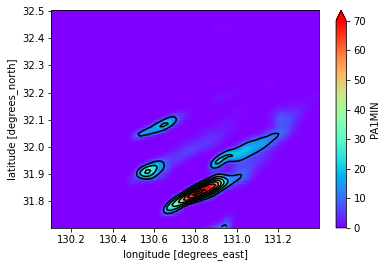

In [11]:
levels = np.arange(10, 1000, 10)
p1h1.plot(cmap=cmap, vmin=vmin, vmax=vmax)
p1h1.plot.contour(levels=levels, colors = 'k')

array(73.15998, dtype=float32)

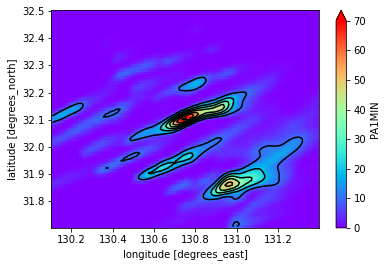

In [26]:
p1h2.plot(cmap=cmap, vmin=vmin, vmax=vmax)
p1h2.plot.contour(levels=levels, colors = 'k')
p1h2.max().compute().values

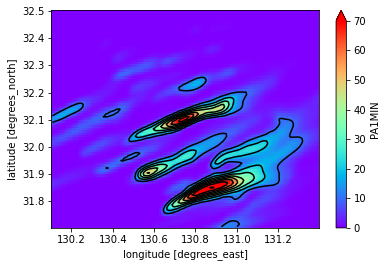

In [13]:
p2h.plot(cmap=cmap, vmin=vmin, vmax=vmax)
p2h.plot.contour(levels=levels, colors = 'k')

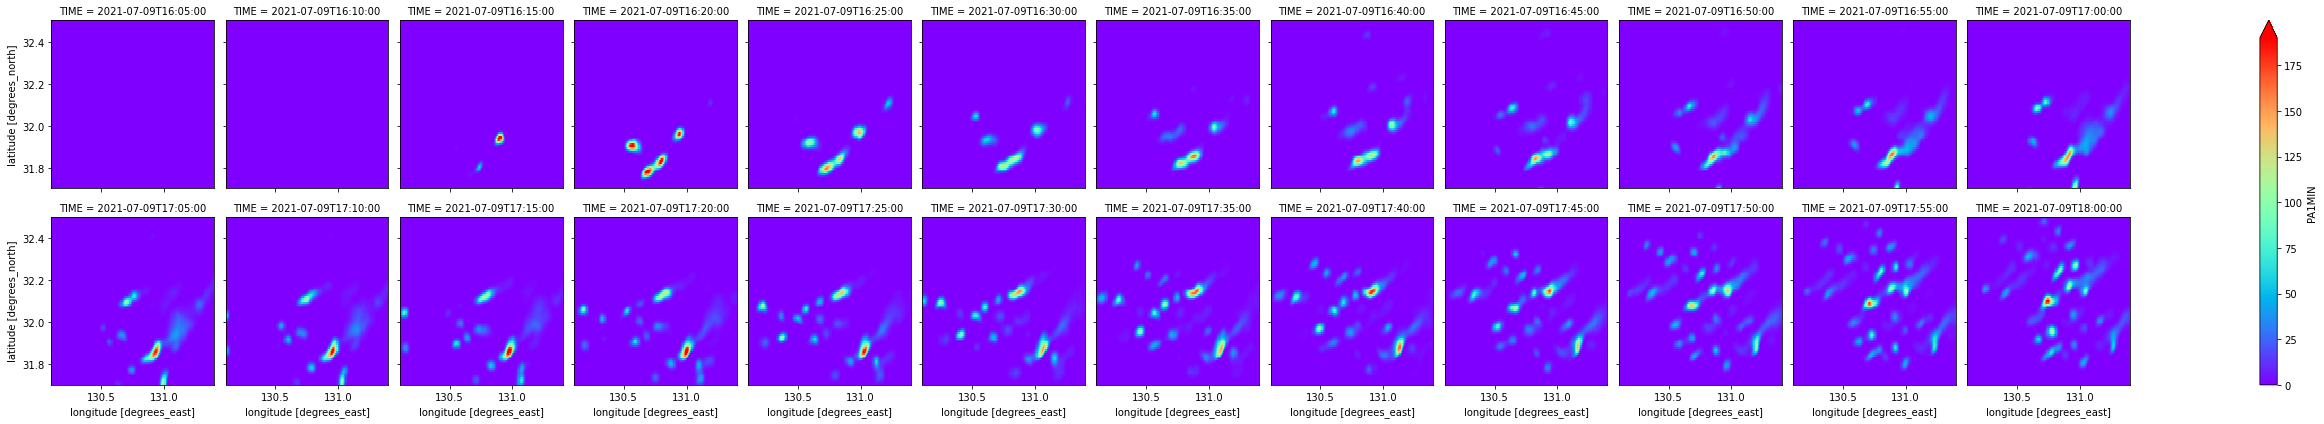

In [34]:
#pd.Timedelta(minutes=5) 
t1 = "2021-07-09T16:05" # 16:01 UTC = 01:01 JST 計算開始
t2 = "2021-07-09T18:00" # 18:00 UTC = 03:00 JST 計算開始
pp = p.sel(TIME=slice(t1, t2, 5))
vmin2 = 0; vmax2 = 190; cmap = "rainbow" 
(pp*60).plot(cmap=cmap, vmin=vmin2, vmax=vmax2, x="LON", y="LAT", col="TIME", col_wrap=12)

In [31]:
# 1分間積算雨量から5分間積算雨量を計算する場合など
def calc_accum(ds, dt):
    def set_attrs(var, dt):
        var.attrs["units"] = "mm/"+ str(dt) +"min"
        var.attrs["long_name"] = str(dt) + " min accumulated rainfall"    

    nt = ds["TIME"].size
    nt2 = int( (nt - 1) / dt + 1)        
    var_in = ds
    var    = var_in.isel(TIME=slice(0,nt,dt)) # array for 10 min accumulated rainfall 
    var[0,:,:] = 0 # 初期時刻の積算雨量は 0 mm であるので、0を代入

    # dt分積算を計算する
    for i in range(1,nt2):
        var[i,:,:] = var_in.isel(TIME=slice(1+dt*(i-1),dt+dt*(i-1))).sum(dim="TIME")

    set_attrs(var, dt)
    return var

In [32]:
p

<xarray.DataArray 'PA1MIN' (TIME: 126, LAT: 89, LON: 144)>
dask.array<getitem, shape=(126, 89, 144), dtype=float32, chunksize=(126, 89, 144), chunktype=numpy.ndarray>
Coordinates:
  * TIME     (TIME) datetime64[ns] 2021-07-09T16:00:00 ... 2021-07-09T18:05:00
  * LAT      (LAT) float64 31.71 31.72 31.72 31.73 ... 32.47 32.48 32.49 32.5
  * LON      (LON) float64 130.1 130.1 130.1 130.1 ... 131.4 131.4 131.4 131.4
Attributes:
    long_name:  accumulated precip.(qr+qs+qg) amount (/monitv)
    units:      mm
    max_value:  300.0
    min_value:  0.0

In [24]:
dt = 1
pp = calc_accum(p, dt)
pp

<xarray.DataArray 'PA1MIN' (TIME: 126, LAT: 55, LON: 111)>
dask.array<setitem, shape=(126, 55, 111), dtype=float32, chunksize=(126, 55, 111), chunktype=numpy.ndarray>
Coordinates:
  * TIME     (TIME) datetime64[ns] 2021-07-09T16:00:00 ... 2021-07-09T18:05:00
  * LAT      (LAT) float64 31.71 31.72 31.72 31.73 ... 32.17 32.17 32.18 32.19
  * LON      (LON) float64 130.1 130.1 130.1 130.1 ... 131.1 131.1 131.1 131.1
Attributes:
    long_name:  1 min accumulated rainfall
    units:      mm/1min
    max_value:  300.0
    min_value:  0.0

In [15]:
pp

<xarray.DataArray 'PA1MIN' (TIME: 126, LAT: 22, LON: 89)>
dask.array<setitem, shape=(126, 22, 89), dtype=float32, chunksize=(126, 22, 89), chunktype=numpy.ndarray>
Coordinates:
  * TIME     (TIME) datetime64[ns] 2021-07-09T16:00:00 ... 2021-07-09T18:05:00
  * LAT      (LAT) float64 32.0 32.01 32.02 32.03 ... 32.17 32.17 32.18 32.19
  * LON      (LON) float64 130.3 130.3 130.3 130.3 ... 131.1 131.1 131.1 131.1
Attributes:
    long_name:  1 min accumulated rainfall
    units:      mm/1min
    max_value:  300.0
    min_value:  0.0